In [107]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl
import yaml

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from itertools import combinations

**Function to compute Tanimoto distance between drug molecules**

In [108]:
def compute_tanimoto_distance_from_df(df):
    """
    Computes Tanimoto distance between all pairs of SMILES strings in a DataFrame.

    Parameters:
    - df: DataFrame with SMILES strings in a column.

    Returns:
    - distances_df: DataFrame containing Tanimoto distances between all pairs of SMILES strings.
    """

    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES']]

    # Calculate fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

    # Compute Tanimoto distance between all pairs of fingerprints
    distances = []

    similarity_df = pd.DataFrame(index=df.index, columns=df.index)
    for i, j in combinations(range(len(df)), 2):
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_df.at[df.index[i], df.index[j]] = tanimoto_similarity
        similarity_df.at[df.index[j], df.index[i]] = tanimoto_similarity
    return similarity_df.fillna(1.0)

**Util functions**

In [137]:
def initialize_model(yaml_config, dest_dir):
    args_rdkit = OmegaConf.create(yaml_config)
    dataloader_rdkit = CellDataLoader(args_rdkit)
    solver_rdkit = IMPAmodule(args_rdkit, dest_dir, dataloader_rdkit)
    return solver_rdkit

class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, channel=None, size=((1.5, 1.5))):
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        if channel == None:
            plt.imshow(img)
        else:
            plt.imshow(img[:,:,channel],"grey")
        plt.axis("off")
        plt.grid("off")
        plt.show()
        if i == n_to_plot:
            break

def transform_by_emb(solver, dataloader, y, n_average, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    y = y.unsqueeze(0)
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)
            # z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().quantile(0.75,0)
            
            # Perturbation ID 
            y_emb = y.repeat((z.shape[0], 1)).cuda()
            y_emb = torch.cat([y_emb, z], dim=1)
            y_emb = solver.nets.mapping_network(y_emb) 
            
            _, X_generated = solver.nets.generator(X_ctr, y_emb)
            transformed.append(t2np(X_generated.detach().cpu()))
            controls.append(t2np(X_ctr.detach().cpu()))
            break
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)

def corrcoef(a, b):
    c = np.cov(a, b)
    d = np.diag(c)
    return c / np.sqrt(d[:, None] * d[None, :])

**Collect drug embeddings**

In [110]:
# bbbbc021_embeddings = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_rdkit.csv", index_col=0)
bbbbc021_embeddings = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_fp.csv", index_col=0)

bbbc021_index = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv")
mol2moa = {mol:y for mol, y in zip(bbbc021_index["CPD_NAME"], bbbc021_index["ANNOT"])}

In [111]:
ood_drugs = ["docetaxel", 
             "AZ841", 
             "cytochalasin D", 
             "simvastatin", 
             "cyclohexamide", 
             "latrunculin B", 
             "epothilone B", 
             "lactacystin", 
             "demecolcine"]

In [112]:
ood_drug_embeddings = bbbbc021_embeddings.loc[ood_drugs]
ood_moa = [mol2moa[mol] for mol in ood_drugs]

In [113]:
metadata = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv", 
                      index_col=0)

metadata_unique = metadata[["CPD_NAME", "SMILES"]]
metadata_unique = metadata_unique.drop_duplicates(subset="CPD_NAME").set_index("CPD_NAME", drop=True)

tanimoto_distance_matrix = compute_tanimoto_distance_from_df(metadata_unique)

tanimoto_distance_matrix.loc[ood_drugs]
mat_tani_second_highest = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
mat_tani_second_highest_ood = mat_tani_second_highest.loc[ood_drugs]

In [105]:
sorted_df

CPD_NAME
cisplatin                 0.032787
DMSO                      0.051724
mitoxantrone              0.153226
mitomycin C               0.156863
floxuridine               0.176471
PP-2                      0.192982
cyclohexamide             0.196429
chlorambucil              0.210084
methotrexate              0.210084
epothilone B              0.214286
latrunculin B             0.216783
AZ138                     0.217054
nocodazole                0.217822
vincristine               0.218182
etoposide                 0.220126
bryostatin                0.230483
camptothecin              0.234234
lactacystin               0.250000
anisomycin                0.252033
alsterpaullone            0.281818
PD-169316                 0.281818
emetine                   0.315789
cytochalasin D            0.542636
cytochalasin B            0.542636
ALLN                      0.552381
MG-132                    0.578947
proteasome inhibitor I    0.578947
docetaxel                 0.726316
taxol      

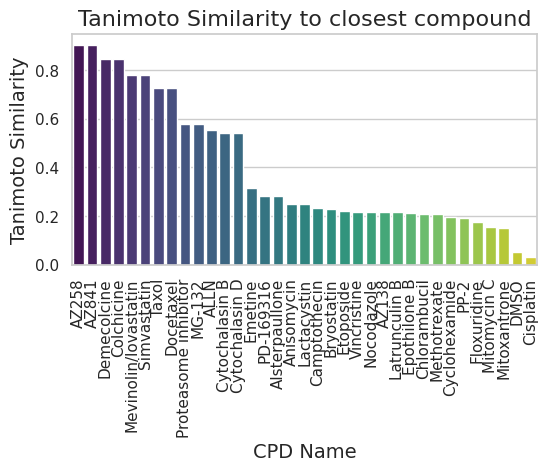

In [106]:
# Capitalize drug names if they are not already in uppercase
new_names = []
for name in mat_tani_second_highest.index:
    if name.isupper():
        new_name = name
    else:
        split_name = name.split(" ")
        if len(split_name) == 1:
            new_name = split_name[0].capitalize()
        else:
            new_name = " ".join([name.split(" ")[0].capitalize(), name.split(" ")[1]])
    new_names.append(new_name)

mat_tani_second_highest.index = new_names

# Sort the Series by the values in descending order
sorted_series = mat_tani_second_highest.sort_values(ascending=False)

# Create the bar plot using Seaborn, flipping it horizontally
plt.figure(figsize=(6, 3))  # Adjust figsize to accommodate the horizontal layout
sns.barplot(x=sorted_series.index, y=sorted_series.values, palette='viridis')  # Swapping x and y

# Set labels and title
plt.xlabel('CPD Name', fontsize=14)  # Swapping xlabel and ylabel
plt.ylabel('Tanimoto Similarity', fontsize=14)
plt.title('Tanimoto Similarity to closest compound', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.savefig('/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/tanimoto_sim.svg',
           dpi=300, bbox_inches='tight', format='svg')

# Show plot
plt.show()

Initialize model

In [73]:
path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

with open(path_to_configs / 'bbbc021_all_retrain_fp.yaml', 'r') as IMPA_bbbc021:
    # Load YAML data using safe_load() from the file
    yaml_IMPA_bbbc021 = yaml.safe_load(IMPA_bbbc021)
    yaml_IMPA_bbbc021["z_dimension"] = 64
    yaml_IMPA_bbbc021["style_dim"] = 128

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240227_aae7c2c6-b1a5-4c2a-851b-0c672502c090_bbbc021_all_retrain_fp"

args = OmegaConf.create(yaml_IMPA_bbbc021)
dataloader = CellDataLoader(args)
IMPA_bbbc021 = initialize_model(yaml_IMPA_bbbc021, dest_dir)

IMPA_bbbc021._load_checkpoint(150)

Number of parameters in generator: 24752771
Number of parameters in style_encoder: 14362304
Number of parameters in discriminator: 14309978
Number of parameters in mapping_network: 139392
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(26, 1024)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fal

In [23]:
# path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

# with open(path_to_configs / 'bbbc021_all_retrain.yaml', 'r') as IMPA_bbbc021:
#     # Load YAML data using safe_load() from the file
#     yaml_IMPA_bbbc021 = yaml.safe_load(IMPA_bbbc021)
#     yaml_IMPA_bbbc021["z_dimension"] =64
#     yaml_IMPA_bbbc021["style_dim"] = 128

# dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240227_d40b5518-ce58-4cb0-87a2-f97ac3bd7ce7_bbbc021_all_retrain"

# args = OmegaConf.create(yaml_IMPA_bbbc021)
# dataloader = CellDataLoader(args)
# IMPA_bbbc021 = initialize_model(yaml_IMPA_bbbc021, dest_dir)

# IMPA_bbbc021._load_checkpoint(150)

## Experiment 1: transform into unseen

In [160]:
drugs = {}
controls = {}

for drug in ood_drugs:
    emb_drug = torch.Tensor(ood_drug_embeddings.loc[drug])
    control, transformed = transform_by_emb(IMPA_bbbc021, dataloader, emb_drug, 1, args)
    drugs[drug] = transformed
    controls[drug] = control

  0%|          | 0/194 [00:04<?, ?it/s]


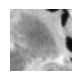

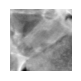

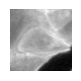

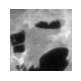

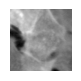

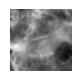

In [168]:
plot_n_images(controls["cytochalasin D"], 5, 0, (0.8,0.8))

docetaxel


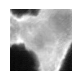

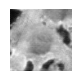

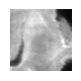

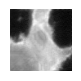

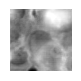

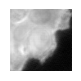

AZ841


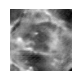

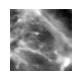

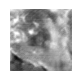

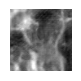

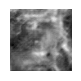

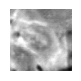

cytochalasin D


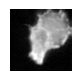

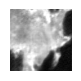

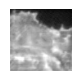

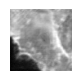

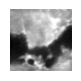

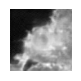

simvastatin


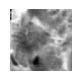

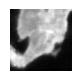

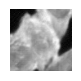

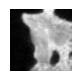

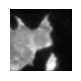

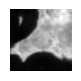

cyclohexamide


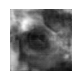

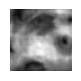

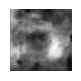

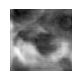

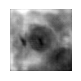

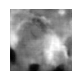

latrunculin B


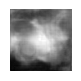

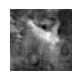

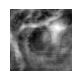

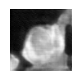

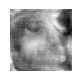

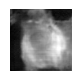

epothilone B


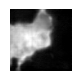

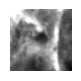

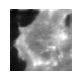

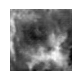

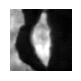

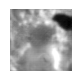

lactacystin


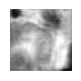

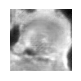

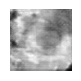

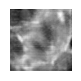

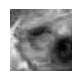

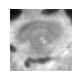

demecolcine


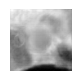

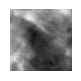

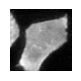

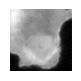

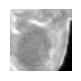

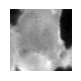

In [165]:
for drug in drug_controls:
    print(drug)
    plot_n_images(drug_controls[drug], 5, 0, (0.8,0.8))

**Try with the old results**

In [119]:
res_file_fp_path = "/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/4.unseen_drug_analysis/results/results_ood_scaled.pkl"
# res_file_fp_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_fp_quantile.pkl"

In [169]:
score

'accuracy'

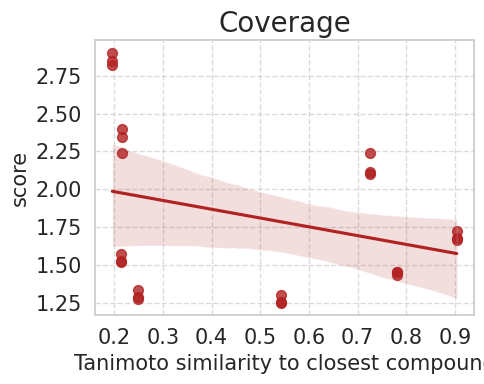

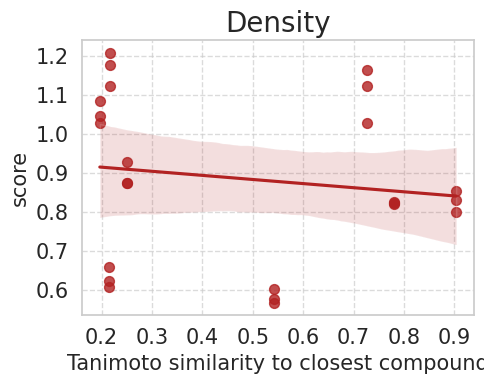

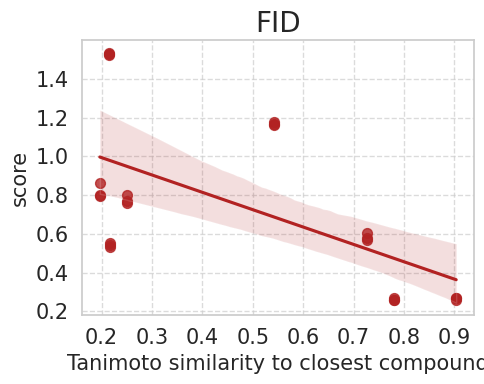

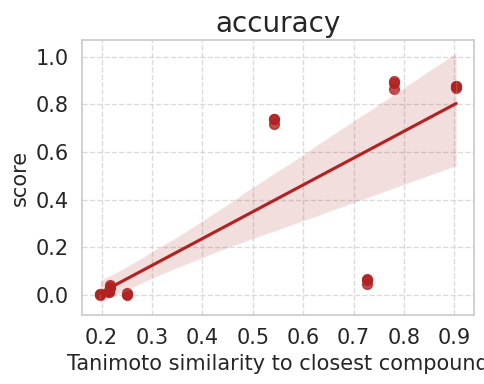

In [181]:
with open(res_file_fp_path, "rb") as file:
    res_file_fp = pkl.load(file)
res_file_fp = res_file_fp.set_index("mol")
res_file_fp = res_file_fp.replace({"1-Accuracy": "accuracy"})
res_file_fp["Correlation closest compound"] = mat_tani_second_highest_ood.loc[res_file_fp.index]
res_file_fp = res_file_fp.loc[res_file_fp.model=="IMPA"]

for score in np.unique(res_file_fp.score_type):
    res_file_fp_score = res_file_fp.loc[res_file_fp.score_type==score]
    plt.figure(figsize=(5, 4))  # Adjust figure size
    
    # Create regplot
    sns.regplot(data=res_file_fp_score, x="Correlation closest compound", y="score", color='firebrick', scatter_kws={"s": 50})
    
    # Title and labels with adjusted font sizes
    plt.title(score, fontsize=20)
    plt.xlabel("Tanimoto similarity to closest compound", fontsize=15)
    plt.ylabel("score", fontsize=15)
    
    # Adjust ticks font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show plot with tight layout
    plt.tight_layout()

    plt.savefig(f"/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/{score}_vs_tanimoto.svg",
           dpi=300,format='svg')
    plt.show()

### Recompute metrics 

In [121]:
correlated = ['docetaxel', 'AZ841', 'cytochalasin D', 'simvastatin']
non_correlated = ['cyclohexamide', 'latrunculin B', 'epothilone B', 'lactacystin']

In [122]:
scores_mol2image = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/4.unseen_drug_analysis/results/results_ood_scaled.pkl')
scores_mol2image = scores_mol2image[scores_mol2image.model=="mol2image"]

scores_mol2image.loc[scores_mol2image['score_type']=='Density', 'score'] = 1 / scores_mol2image.loc[scores_mol2image['score_type']=='Density', 'score']
scores_mol2image.loc[scores_mol2image['score_type']=='Coverage', 'score'] = 1 / scores_mol2image.loc[scores_mol2image['score_type']=='Coverage', 'score']
scores_mol2image.loc[scores_mol2image['score_type']=='FID', 'score'] = 1 / scores_mol2image.loc[scores_mol2image['score_type']=='FID', 'score']
scores_mol2image.loc[scores_mol2image['score_type']=='FID', 'score_type'] = u'FID\u207B\u00B9'

scores_mol2image = scores_mol2image.replace({"1-Accuracy": "Accuracy"})

In [123]:
scores_mol2image.groupby(["model", "score_type"]).mean()

/tmp/ipykernel_1801302/1416709393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_mol2image.groupby(["model", "score_type"]).mean()


score  run
model     score_type               
mol2image Accuracy    0.002063  1.0
          Coverage    0.088023  1.0
          Density     1.303013  1.0
          FID⁻¹       0.562316  1.0

In [124]:
scores = pd.concat([res_file_fp.reset_index().drop(columns="Correlation closest compound"), scores_mol2image], axis=0)

In [125]:
scores.loc[scores['score_type']=='FID', 'score'] = 1 / scores.loc[scores['score_type']=='FID', 'score']
scores.loc[scores['score_type']=='FID', 'score_type'] = u'FID\u207B\u00B9'

In [126]:
# Add average score
grouping = scores.groupby(['model'], as_index=False).mean()
grouping['score_type']='average'
grouping['mol'] = 'all'
grouping['dataset'] = grouping['model']


complete_score = pd.concat([scores, grouping])
complete_score = complete_score.loc[complete_score.mol.isin(correlated+['all'])]
complete_score = complete_score.replace('mol2image', 'Mol2Image')

complete_score = complete_score.replace({"Accuracy": "accuracy", 
                                            "Density": "density", 
                                            "Coverage": "coverage"})

/tmp/ipykernel_1801302/4236139275.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouping = scores.groupby(['model'], as_index=False).mean()


In [127]:
complete_score

,mol,score,score_type,run,model,dataset
0,docetaxel,1.753790,FID⁻¹,0.0,IMPA,NaN
1,docetaxel,1.124511,density,0.0,IMPA,NaN
2,docetaxel,2.115194,coverage,0.0,IMPA,NaN
3,docetaxel,0.065217,accuracy,0.0,IMPA,NaN
4,AZ841,3.720146,FID⁻¹,0.0,IMPA,NaN
...,...,...,...,...,...,...
173,simvastatin,1.289300,density,2.0,Mol2Image,NaN
174,simvastatin,0.059701,coverage,2.0,Mol2Image,NaN
175,simvastatin,0.006500,accuracy,2.0,Mol2Image,NaN
0,all,1.231119,average,1.0,IMPA,IMPA


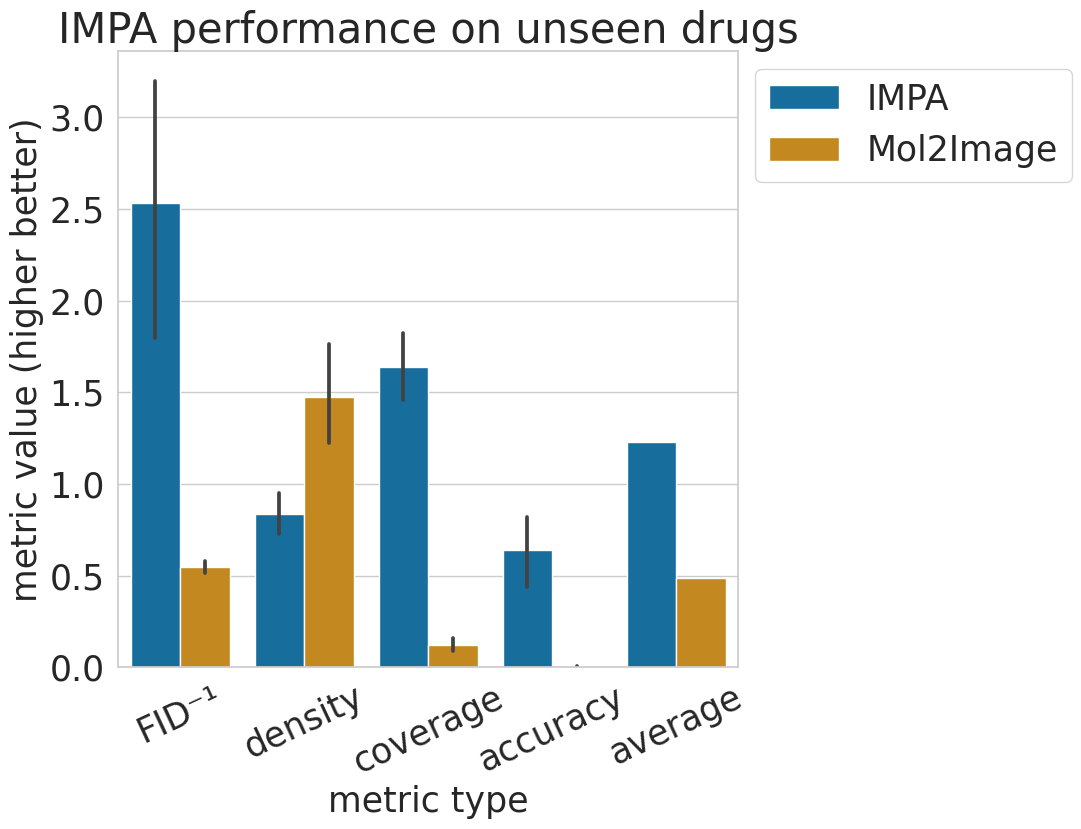

In [145]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=complete_score,
                x='score_type',
                y='score',
                hue='model',
                palette='colorblind',
                orient='v')

ax.tick_params(axis='x', rotation=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.ylabel('metric value (higher better)', fontsize=25)
plt.xlabel('metric type', fontsize=25)
plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 25})
plt.title('IMPA performance on unseen drugs', fontsize=30)
plt.savefig("/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/updated_performance_unseen.svg",
           dpi=300,format='svg')

plt.show()